 <a id="top"></a> <br>
## Notebook  Content
*  [Introduction/  1.How can the crime rate of a country be measured?](#1)
*  [Analysis of USA first](#2)
1. [Crime data (loading and pre-processing is a bit lentghy)](#3)


<a id="1"></a> <br>
# 1. How can the crime rate of a country be measured?


Starting of with the first question we can use the official definiton of FBI which classifies homicide, rape, robbery and assault  as violent crime and the true criminality of a country wont be skeewed by non-relevant crimes (if such thing exists). Ofcourse some other categories can come into the story, but I think these should be the main aspect. Same metrics that apply for the countries of the world apply for US States (the first analysis) BUT when we collected these measuraments for the countries of the world a strange pattern emerged: Sweden, German etc were on top of the list. And to quote myself as I said (underneath when second question was answered)

"WHAT? It does not make any sence. Sweden? It is because people have more trust, less corruption, better reporting system punishments etc... IN ORDER To mitigate this effect and get the TRUE levels we ought to normalise these values with all of the values/data that I just named, and even more since these are just some of the factors that influence the odd results. That implies finding ALL of these datasets that coincide with ALL of the countries on ALL of the years. "

So we searched for some indicators that could remove this effect and we found "Rule of law" and "Corruption index" (its underneath when reading in the crime data for the entire world). And we did find that this approach paints a better picture of a crime rate of  a country. (As we shall see later on)


In [77]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warnings (as always)
from sklearn.linear_model import ElasticNetCV, LinearRegression


import plotly.figure_factory as ff
import plotly.offline as py
##for online plotting use import plotly.plotly as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
from plotly import tools
import gc
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import plotly.express as px


First of all we are going to do some **introductory analysis** that should serve as an baby example for the actual one. **Crime Analysis of US States** (with some small Analysis of NYC). Datasets for USA is usually excellant and we did not have to wrestle with it just find a way to answer the questions. If one whishes to skip analysis of USA than scroll down over to 
### Crime Data

<a id="2"></a> <br>
# US States Analysis


Now let us load an US data set containing 4 types of violent crime in major US cities (cities with over 250 000 citizens). This should serve as a templete to an (almost) perfect data set that we need to find. We have 40 years of data, there are 4 types of different crimes reported all through out the year. Further more we have clearly distinct areas with additional number of population for each area.

In [78]:
file_path = "/Users/margarita/Downloads/report.csv"
df2 = pd.read_csv(file_path, encoding='latin1')
df2

,report_year,agency_code,agency_jurisdiction,population,violent_crimes,homicides,rapes,assaults,robberies,months_reported,crimes_percapita,homicides_percapita,rapes_percapita,assaults_percapita,robberies_percapita
0,1975,NM00101,"Albuquerque, NM",286238.0,2383.0,30.0,181.0,1353.0,819.0,12.0,832.52,10.48,63.23,472.68,286.13
1,1975,TX22001,"Arlington, TX",112478.0,278.0,5.0,28.0,132.0,113.0,12.0,247.16,4.45,24.89,117.36,100.46
2,1975,GAAPD00,"Atlanta, GA",490584.0,8033.0,185.0,443.0,3518.0,3887.0,12.0,1637.44,37.71,90.30,717.10,792.32
3,1975,CO00101,"Aurora, CO",116656.0,611.0,7.0,44.0,389.0,171.0,12.0,523.76,6.00,37.72,333.46,146.58
4,1975,TX22701,"Austin, TX",300400.0,1215.0,33.0,190.0,463.0,529.0,12.0,404.46,10.99,63.25,154.13,176.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2824,2015,OK07205,"Tulsa, OK",401520.0,3628.0,55.0,365.0,2354.0,854.0,NaN,903.57,13.70,90.90,586.27,212.69
2825,2015,VA12800,"Virginia Beach, VA",452797.0,626.0,19.0,103.0,234.0,270.0,NaN,138.25,4.20,22.75,51.68,59.63
2826,2015,DCMPD00,"Washington, DC",672228.0,8084.0,162.0,494.0,4024.0,3404.0,NaN,1202.57,24.10,73.49,598.61,506.38
2827,2015,KS08703,"Wichita, KS",389824.0,3839.0,27.0,349.0,2730.0,733.0,NaN,984.80,6.93,89.53,700.32,188.03


Now us do some EDA to get to know our complete data set

In [79]:

# Assuming df2 is your dataframe, sum the crime columns
df2['total_crimes'] = df2['violent_crimes'] + df2['homicides'] + df2['rapes'] + df2['assaults'] + df2['robberies']

# Now you can group by the 'State' or 'agency_jurisdiction' (if needed) and aggregate the total crimes
# If you want to aggregate by state, extract the state from the 'agency_jurisdiction'
df2['State'] = df2['agency_jurisdiction'].str.split(',').str[-1].str.strip()

# Group by state and aggregate total crimes
state_crime_data = df2.groupby('State', as_index=False).agg({
    'total_crimes': 'sum',  # Sum of all crime types for each state
    'population': 'sum'     # Sum of population for each state (optional)
})

# Normalize the total crimes by dividing by 1 million (optional)
state_crime_data['total_crimes_million'] = state_crime_data['total_crimes'] / 1e6

# Define the min and max values for scaling
min_crimes = state_crime_data['total_crimes_million'].min()
max_crimes = state_crime_data['total_crimes_million'].max()

# Create the choropleth map using Plotly Express
fig = px.choropleth(
    state_crime_data,
    locations='State',
    locationmode='USA-states',
    color='total_crimes_million',  # Use the total crime values
    scope='usa',
    color_continuous_scale='RdBu',  # Color scale
    title='Total Crimes by State (1975-2015)',
    labels={'total_crimes_million': 'Total Crimes (millions)'},
    range_color=[min_crimes, max_crimes]  # Set custom range (0 to 5 million)
)

fig.update_geos(
    visible=True,
    projection_type='albers usa',  # Optional: to change the projection type
    showland=True,
    showcoastlines=True,
    coastlinecolor='black',  # Coastlines to black
    oceancolor='darkblue',  # Set the ocean (non-land) color
)

# Set the background to black
fig.update_layout(
    plot_bgcolor='black',  # Set the plot area background to black
    paper_bgcolor='white',  # Set the surrounding area to black
    font=dict(color='black'),  # Set font color to white to be visible on black background
    title_font=dict(size=24, color='black'),  # Title font color and size
    geo_scope='usa'  # Focus on the United States map
)

# Show the plot
fig.show()


There are a couple of things that are interesting here. First of all city "United States" is the sum of them all. Further more New York, LA, Chicago seem to be most violent, or is it because of the shere number of citizens in these towns? How can we investigate it? Let us creeate a new variable that is relative to the number of citizens, i.e. total number of crime divided with total citizens. (NOTE: Black line is simply confidence interval of estimation)

# Main metric that we are trying to predict:

In [80]:

df2["relative_crime"]=(df2["violent_crimes"]+df2["homicides"]+
                 df2["rapes"]+df2["assaults"]+df2["robberies"])/df2.population



In [81]:


# Group by state and aggregate total crimes
state_crime_data = df2.groupby('State', as_index=False).agg({
    'relative_crime': 'sum',  # Sum of all crime types for each state
    'population': 'sum'     # Sum of population for each state (optional)
})

# Normalize the total crimes by dividing by 1 million (optional)
state_crime_data['relative_crime'] = state_crime_data['relative_crime'] / 1e6

# Define the min and max values for scaling
min_crimes = state_crime_data['relative_crime'].min()
max_crimes = state_crime_data['relative_crime'].max()

# Create the choropleth map using Plotly Express
fig = px.choropleth(
    state_crime_data,
    locations='State',
    locationmode='USA-states',
    color='relative_crime',  # Use the total crime values
    scope='usa',
    color_continuous_scale='RdBu',  # Color scale
    title='Total Crimes by State (1975-2015)',
    labels={'total_crimes_million': 'Total Crimes (millions)'},
    range_color=[min_crimes, max_crimes]  # Set custom range (0 to 5 million)
)

fig.update_geos(
    visible=True,
    projection_type='albers usa',  
    showland=True,
    showcoastlines=True,
    coastlinecolor='black', 
    oceancolor='darkblue', 
)

fig.update_layout(
    plot_bgcolor='black',  
    paper_bgcolor='white', 
    font=dict(color='black'),  
    title_font=dict(size=24, color='black'), 
    geo_scope='usa' 
)

# Show the plot
fig.show()


That paints another picture, now top of the list is St.Louis, Atlanta, Miami etc. That was interesting, but was it always like that? What was the number of crimes over the years?

In [82]:
import plotly.offline as py
import plotly.graph_objs as go

py.init_notebook_mode(connected=True)
plt.style.use('dark_background')

# Filter the DataFrame to only include New York
ny_data = df2[df2['agency_jurisdiction'].str.contains("New York")]

# Create the scatter trace for New York
trace_ny = go.Scatter(
    x=ny_data['report_year'], 
    y=ny_data['violent_crimes'], 
    name="New York", 
    opacity=0.8
)

# Define the layout
layout = dict(
    title="Total Crimes in New York over 40 years",
    xaxis=dict(title='Time Span'),
    yaxis=dict(title='Cumulative Crimes'),
)

# Prepare the figure with the New York trace
fig = dict(data=[trace_ny], layout=layout)

# Plot the figure
py.iplot(fig)


Now from here we can set a lot of interesting question. One of them would be why was crime in NYC in 90-s so high? Well there seems to be a couple of factors (we state them, not test them) For example, the police force in New York City grew by 35 percent in the 1990s, the numbers of prison inmates rose 24 percent, and there were demographic changes, including a decline in the number of youths. The national unemployment rate declined 25 percent between 1990 and 1999, and by 39 percent in the city between 1992 and 1999. This study shows that a single percentage point decline in the jobless rate decreases burglary by 2.2 percent and motor vehicle theft by 1.8 percent. Increases in the real minimum wage also significantly reduce robberies and murders: 3.4 to 3.7 percent fewer robberies with a 10 percent increase in the minimum wage and 6.3 to 6.9 percent fewer murders. And ofcourse police measures.The police measure that most consistently reduces crime is the arrest rate of those involved in crime, the study finds. Felony arrest rates (except for motor vehicle thefts) rose 50 to 70 percent in the 1990s. When arrests of burglars increased 10 percent, the number of burglaries fell 2.7 to 3.2 percent. When the arrest rate of robbers rose 10 percent, the number of robberies fell 5.7 to 5.9 percent. In the case of murder, the decline was 3.9 to 4 percent; in the case of assault, 2 to 2.4 percent; and for motor vehicle theft, 5 to 5.1 percent. Could a mayor have helped in reducing crime?

Let us now jumpt to conculusions, correlation is not causation but David Dinkins must have helped. New York city seems interesting since on the absolute scale it has the most crime in the entire United States. Let us dig deeper in NYC.

NameError: name 'NYC' is not defined

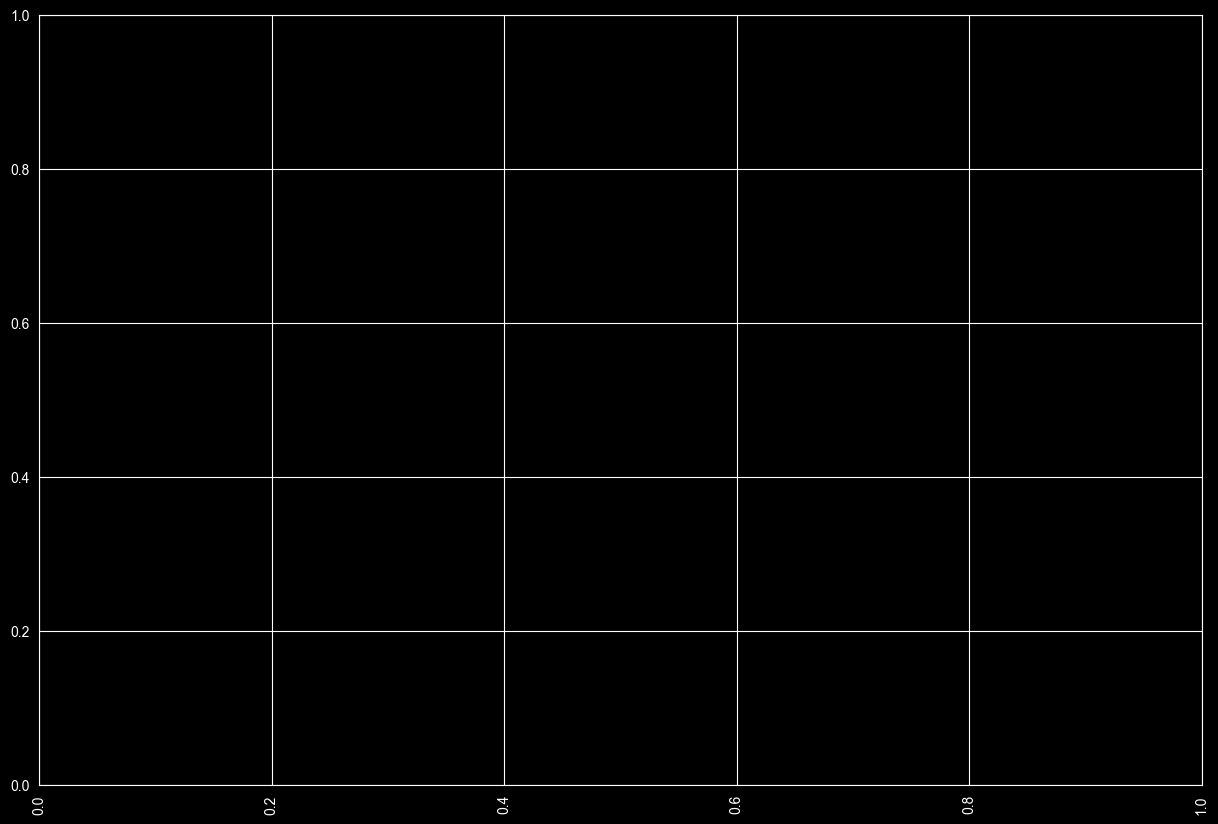

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

# Set up the figure size
plt.figure(figsize=(15, 10))

# Rotate the x-axis labels vertically
plt.xticks(rotation='vertical')

# Plot the bar plot using seaborn
sns.barplot(x=NYC["report_year"], y=NYC["rapes"], palette="cubehelix")

# Set the y-axis label
plt.ylabel("Number of Rapes")

# Set the title of the plot (optional but helpful)
plt.title("Rapes in New York City Over the Years")

# Show the plot
plt.show()


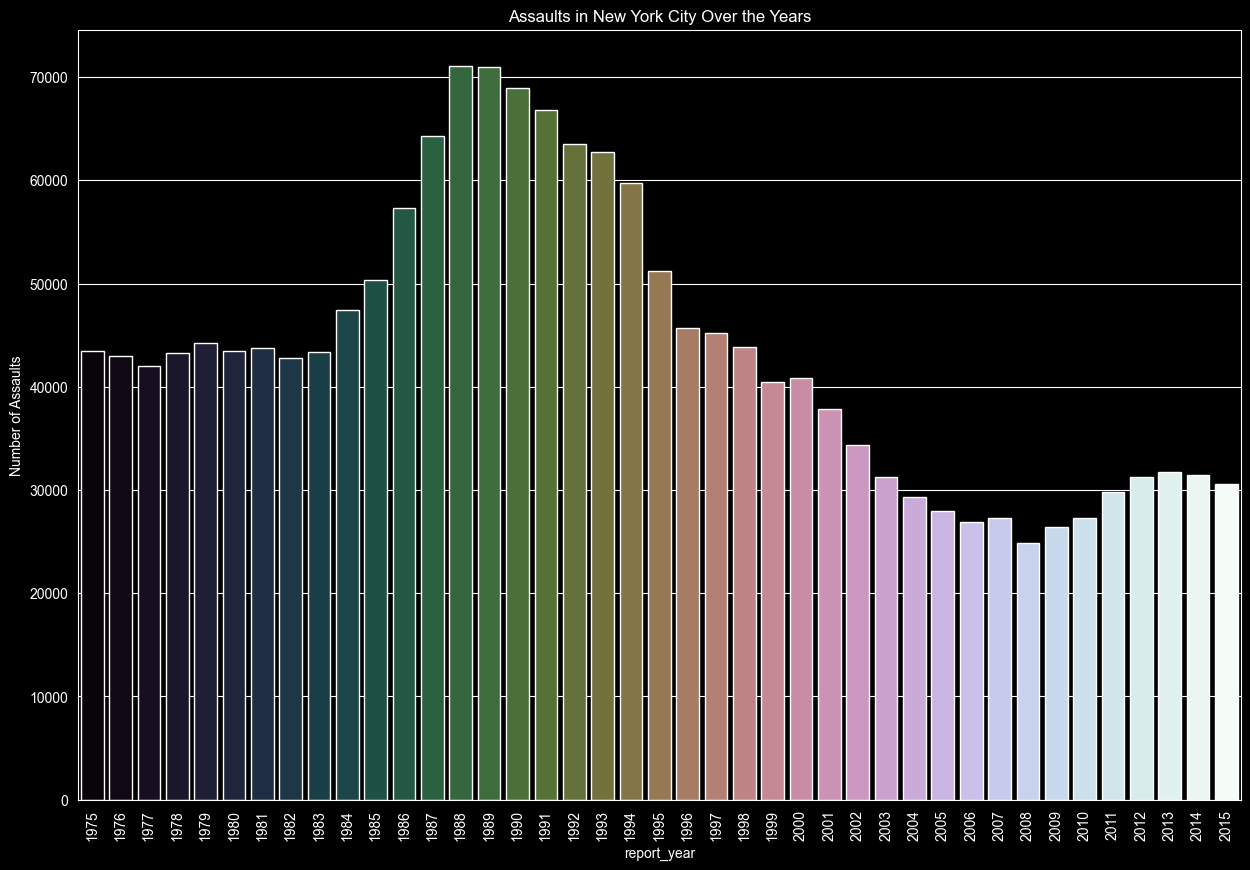

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

# Set up the figure size
plt.figure(figsize=(15, 10))

# Rotate the x-axis labels vertically
plt.xticks(rotation='vertical')

# Plot the bar plot using seaborn
sns.barplot(x=NYC["report_year"], y=NYC["assaults"], palette="cubehelix")

# Set the y-axis label
plt.ylabel("Number of Assaults")

# Set the title of the plot (optional but helpful)
plt.title("Assaults in New York City Over the Years")

# Show the plot
plt.show()


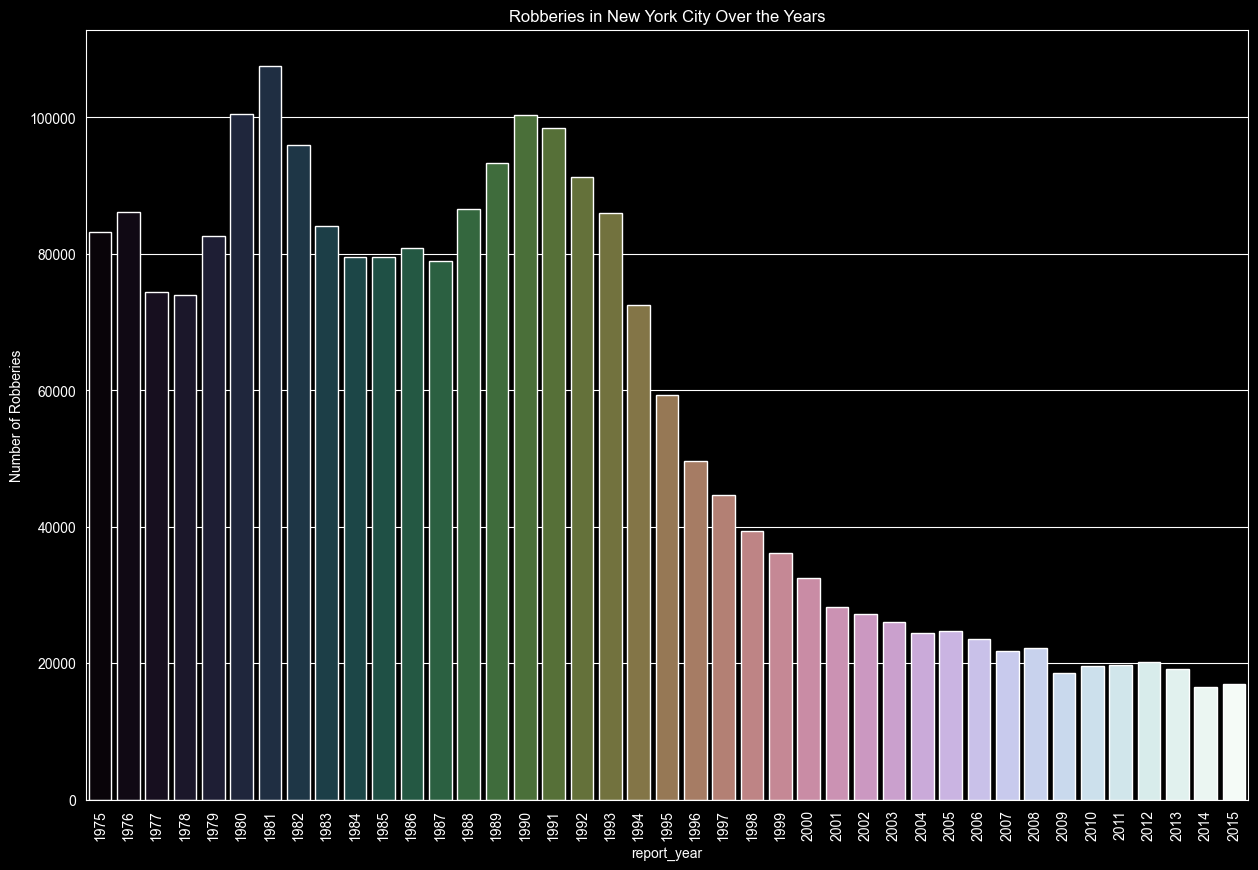

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

# Set up the figure size
plt.figure(figsize=(15, 10))

# Rotate the x-axis labels vertically
plt.xticks(rotation='vertical')

# Plot the bar plot using seaborn
sns.barplot(x=NYC["report_year"], y=NYC["robberies"], palette="cubehelix")

# Set the y-axis label
plt.ylabel("Number of Robberies")

# Set the title of the plot (optional but helpful)
plt.title("Robberies in New York City Over the Years")

# Show the plot
plt.show()


We have analyzed NYC enough, let us now try to find some socio-economic data, and try to see if we can use it to predict crime rate all around US. But how do we quantify successful state? NY state is quite successful at the first glance, but it is at the top of our list for crime. A couple that we should look for and that are at the top of my mind are: Unemployment Rate,Worker Productivity,Startup Activity,Median Household Income,Upward Mobility Rates,Road Quality,Public Utility Fee Rates,Overall Tax Burden  etc etc... I managed to dig up 2 interesting datasets. First if US unemplyment by county and state from 1990 until 2016 and Zillow Rent Index from 2010 until 2017. Hypothesis is simple, where there was a lot of unemplyment and biggest living factor (rent) was high ->>> more crime. Let us test that. But before we do that, we need to merge the datasets together.

<a id="3"></a> <br>
# Crime Data

In [85]:
df = pd.read_csv('/Users/margarita/Downloads/Crimes_UN_data.csv', skiprows=[0], encoding='latin1')
df.head()

,Region/Country/Area,Unnamed: 1,Year,Series,Value,Footnotes,Source
0,1,"Total, all countries or areas",2015,"Intentional homicide rates per 100,000",5.3,"Data is for 2015, or latest available data fro...",United Nations Office on Drugs and Crime (UNOD...
1,202,Sub-Saharan Africa,2015,"Intentional homicide rates per 100,000",9.6,"Data is for 2015, or latest available data fro...",United Nations Office on Drugs and Crime (UNOD...
2,419,Latin America & the Caribbean,2015,"Intentional homicide rates per 100,000",22.3,"Data is for 2015, or latest available data fro...",United Nations Office on Drugs and Crime (UNOD...
3,62,South-central Asia,2015,"Intentional homicide rates per 100,000",3.7,"Data is for 2015, or latest available data fro...",United Nations Office on Drugs and Crime (UNOD...
4,53,Australia and New Zealand,2015,"Intentional homicide rates per 100,000",1,"Data is for 2015, or latest available data fro...",United Nations Office on Drugs and Crime (UNOD...


Very ugly data frame, let us try to clean it up and keep only the desired columns

In [86]:
cols = list(df.columns)
cols[1] = 'Region'
df.columns = cols
pivoted = pd.pivot_table(df, values='Value', index=['Region', 'Year'], columns='Series', aggfunc=sum)
un_crimes=pivoted
pivoted.head()

Series           Assault rate per 100,000 population  \
Region      Year                                       
Afghanistan 2010                                 NaN   
            2012                                 NaN   
Albania     2005                                 5.4   
            2010                                 6.1   
            2015                                 5.8   

Series           Intentional homicide rates per 100,000  \
Region      Year                                          
Afghanistan 2010                                    3.4   
            2012                                    6.3   
Albania     2005                                      5   
            2010                                    4.3   
            2015                                    2.3   

Series           Kidnapping at the national level, rate per 100,000  \
Region      Year                                                      
Afghanistan 2010                                                NaN   
            2012                                                NaN   
Albania     2005                                                NaN   
            2010                                                0.3   
            2015                                                0.3   

Series           Percentage of male and female intentional homicide victims, Female  \
Region      Year                                                                      
Afghanistan 2010                                                NaN                   
            2012                                                0.6                   
Albania     2005                                                1.4                   
            2010                                                1.3                   
            2015                                                  1                   

Series           Percentage of male and female intentional homicide victims, Male  \
Region      Year                                                                    
Afghanistan 2010                                                NaN                 
            2012                                               11.8                 
Albania     2005                                                8.6                 
            2010                                                7.3                 
            2015                                                3.5                 

Series           Robbery at the national level, rate per 100,000 population  \
Region      Year                                                              
Afghanistan 2010                                                NaN           
            2012                                                NaN           
Albania     2005                                                6.5           
            2010                                                8.1           
            2015                                                8.1           

Series           Theft at the national level, rate per 100,000 population  \
Region      Year                                                            
Afghanistan 2010                                                NaN         
            2012                                                NaN         
Albania     2005                                               96.9         
            2010                                              137.1         
            2015                                              248.1         

Series           Total Sexual Violence at the national level, rate per 100,000  
Region      Year                                                                
Afghanistan 2010                                                NaN             
            2012                                                NaN             
Albania     2005                                                2.9    

How do we even impute this? Basic methods like foreward fill and others are out of the question since they are obviously false for many reasons. There is an option to import another data set containing socio-economic variables and based on that try to predict the missing values. In essence build a model to predict the missing values. Problem with that is that we have too little training data, i.e. for Afganistan we have only two. Algorithm can not learn with that. I decided to set the NaN values to zero and atleast extract some statistics and interesing plots from the data at hand. And we are going to supplement with other data sources later on.

In [87]:
pivoted=pivoted.fillna(0)

Second question can partially be answered with the dataset at hand:

1. Which countries have the highest/lowest crime rates?(Full/complementary answer later on)

3. Obviously very rialable signs of a country crime rate are 5 columns : Assault rate per 100,000 population, Intentional homicide rates per 100,000, Robbery at the national level, rate per 100,000 population, Theft at the national level, rate per 100,000 population, Total Sexual Violence at the national level, rate per 100,000 They are all normed to 100 000 citizens and describe various hard-crimes.

4. We can answer with Table of maximum values for all 5 different types of crime

In [88]:
pivoted.loc[pivoted.index.get_level_values(0)]

Series           Assault rate per 100,000 population  \
Region      Year                                       
Afghanistan 2010                                   0   
            2012                                   0   
            2010                                   0   
            2012                                   0   
Albania     2005                                 5.4   
...                                              ...   
Zimbabwe    2012                                   0   
            2005                               712.5   
            2008                               379.7   
            2010                                   0   
            2012                                   0   

Series           Intentional homicide rates per 100,000  \
Region      Year                                          
Afghanistan 2010                                    3.4   
            2012                                    6.3   
            2010                                    3.4   
            2012                                    6.3   
Albania     2005                                      5   
...                                                 ...   
Zimbabwe    2012                                    6.7   
            2005                                   10.4   
            2008                                      0   
            2010                                      5   
            2012                                    6.7   

Series           Kidnapping at the national level, rate per 100,000  \
Region      Year                                                      
Afghanistan 2010                                                  0   
            2012                                                  0   
            2010                                                  0   
            2012                                                  0   
Albania     2005                                                  0   
...                                                             ...   
Zimbabwe    2012                                                  0   
            2005                                                0.3   
            2008                                                1.6   
            2010                                                  0   
            2012                                                  0   

Series           Percentage of male and female intentional homicide victims, Female  \
Region      Year                                                                      
Afghanistan 2010                                                  0                   
            2012                                                0.6                   
            2010                                                  0                   
            2012                                                0.6                   
Albania     2005                                                1.4                   
...                                                             ...                   
Zimbabwe    2012                                                  2                   
            2005                                                  0                   
            2008                                                  0                   
            2010                                                  0                   
            2012                                                  2                   

Series           Percentage of male and female intentional homicide victims, Male  \
Region      Year                                                                    
Afghanistan 2010                                                  0                 
            2012                                               11.8                 
            2010                                                  0                 
            2012      

In [ ]:
pivoted_max= pivoted.copy()  

for column in pivoted_max.columns:
    if pivoted_max[column].dtype == 'object':
        pivoted_max[column] = pivoted_max[column].replace({',': '', '%': '', ' ': ''}, regex=True)
        pivoted_max[column] = pd.to_numeric(pivoted_max[column], errors='coerce')

pivoted_max=pivoted_max.fillna(0)
pivoted_max["Intentional homicide rates per 100,000"]=pivoted_max["Intentional homicide rates per 100,000"].astype('float')
pivoted_max["Robbery at the national level, rate per 100,000 population"]=pivoted_max["Robbery at the national level, rate per 100,000 population"].astype('float')
pivoted_max["Assault rate per 100,000 population"]=pivoted_max["Assault rate per 100,000 population"].astype('float')

pivoted_max1=pivoted_max.sort_values(by="Intentional homicide rates per 100,000",ascending=False)
pivoted_max

Series            Assault rate per 100,000 population  \
Region      Year                                        
Afghanistan 2010                                  0.0   
            2012                                  0.0   
Albania     2005                                  5.4   
            2010                                  6.1   
            2015                                  5.8   
...                                               ...   
Zambia      2015                                  0.0   
Zimbabwe    2005                                712.5   
            2008                                379.7   
            2010                                  0.0   
            2012                                  0.0   

Series            Intentional homicide rates per 100,000  \
Region      Year                                           
Afghanistan 2010                                     3.4   
            2012                                     6.3   
Albania     2005                                     5.0   
            2010                                     4.3   
            2015                                     2.3   
...                                                  ...   
Zambia      2015                                     5.3   
Zimbabwe    2005                                    10.4   
            2008                                     0.0   
            2010                                     5.0   
            2012                                     6.7   

Series            Kidnapping at the national level, rate per 100,000  \
Region      Year                                                       
Afghanistan 2010                                                0.0    
            2012                                                0.0    
Albania     2005                                                0.0    
            2010                                                0.3    
            2015                                                0.3    
...                                                             ...    
Zambia      2015                                                0.0    
Zimbabwe    2005                                                0.3    
            2008                                                1.6    
            2010                                                0.0    
            2012                                                0.0    

Series            Percentage of male and female intentional homicide victims, Female  \
Region      Year                                                                       
Afghanistan 2010                                                0.0                    
            2012                                                0.6                    
Albania     2005                                                1.4                    
            2010                                                1.3                    
            2015                                                1.0                    
...                                                             ...                    
Zambia      2015                                                2.1                    
Zimbabwe    2005                                                0.0                    
            2008                                                0.0                    
            2010                                                0.0                    
            2012                                                2.0                    

Series            Percentage of male and female intentional homicide victims, Male  \
Region      Year                                                                     
Afghanistan 2010                                                0.0                  
            2012                                               11.8                  
Albania     2005                                   

It appears that the second column "Intentional homicide rates per 100,000" is mostly populated, so we can make some inference from it!

<Axes: title={'center': 'Intentional homicide rates per 100,000'}, xlabel='Region,Year'>

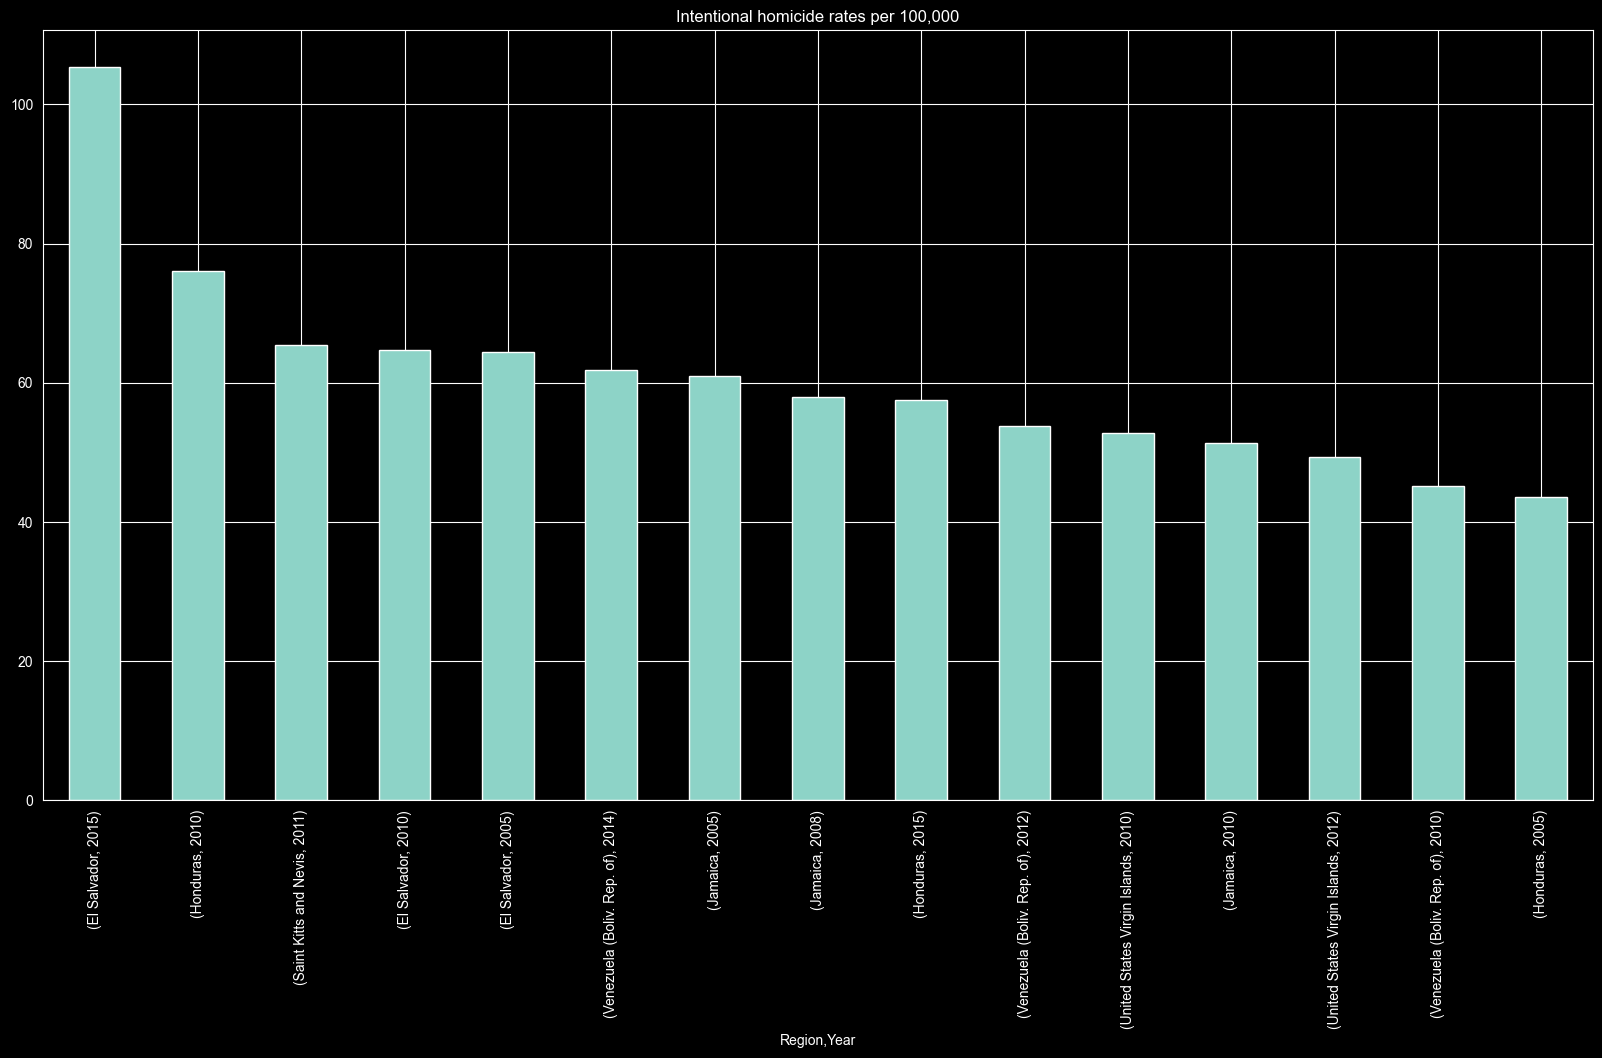

In [90]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(20, 10))
pivoted_max1['Intentional homicide rates per 100,000'].head(15).plot(kind='bar', rot=90,  title='Intentional homicide rates per 100,000')

<Axes: title={'center': 'Robbery at the national level, rate per 100,000 population'}, xlabel='Region,Year'>

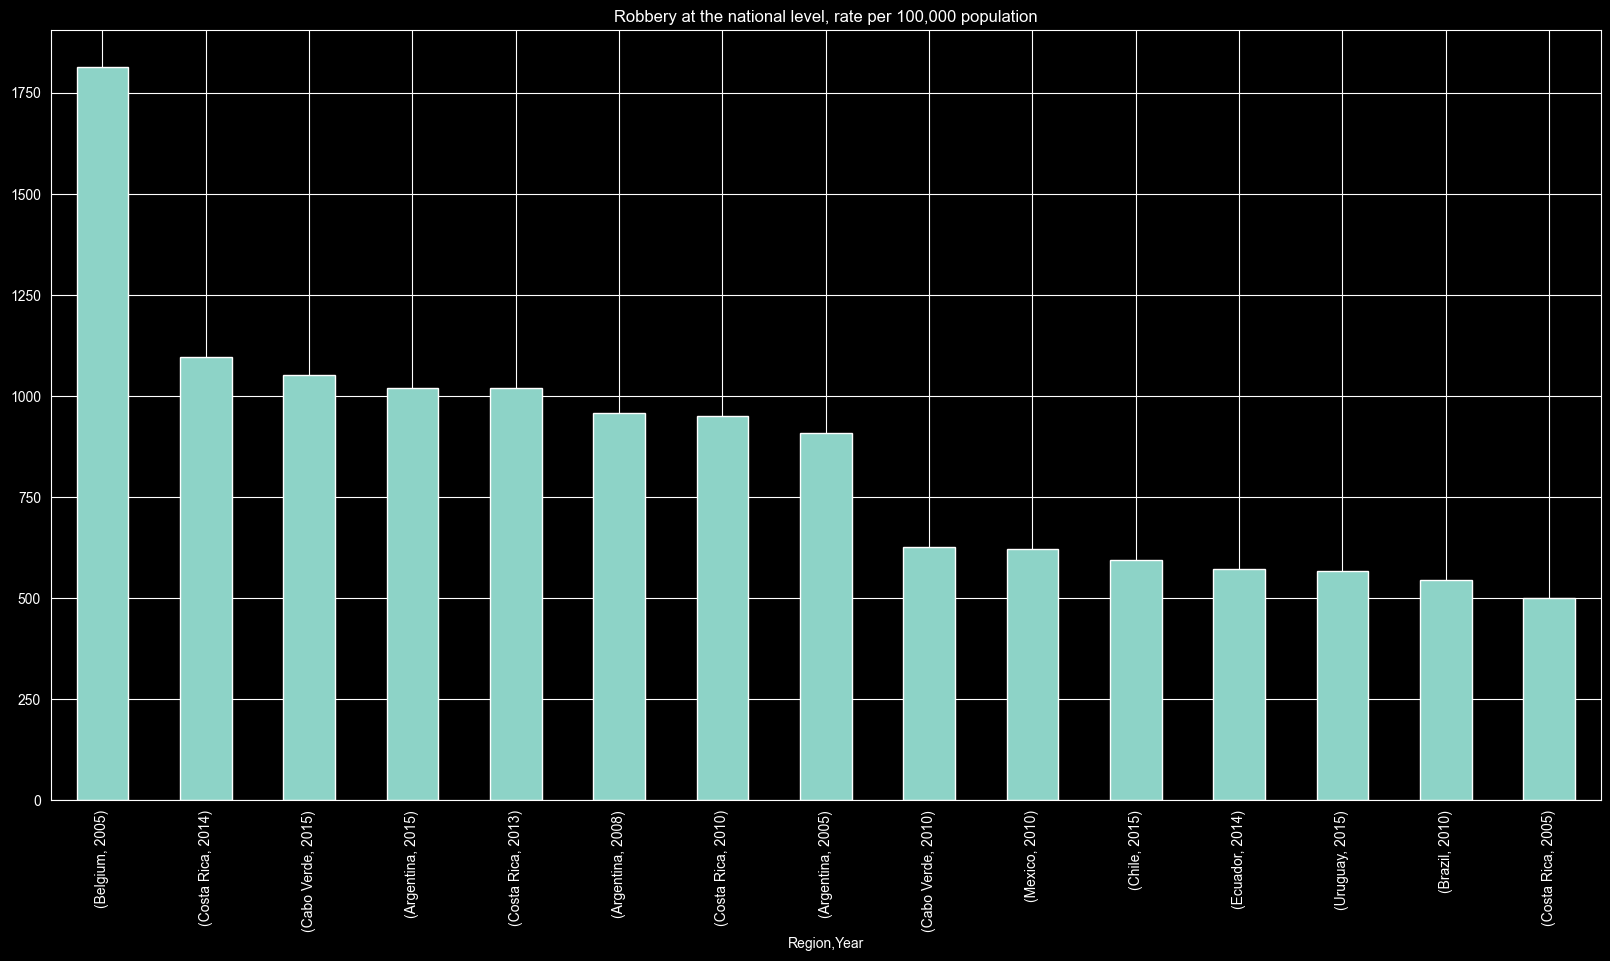

In [91]:
pivoted_max2=pivoted_max.sort_values(by="Robbery at the national level, rate per 100,000 population",ascending=False)
fig, ax = plt.subplots(figsize=(20, 10))
pivoted_max2['Robbery at the national level, rate per 100,000 population'].head(15).plot(kind='bar', rot=90,  title='Robbery at the national level, rate per 100,000 population')

<Axes: title={'center': 'Assault rate per 100,000 population'}, xlabel='Region,Year'>

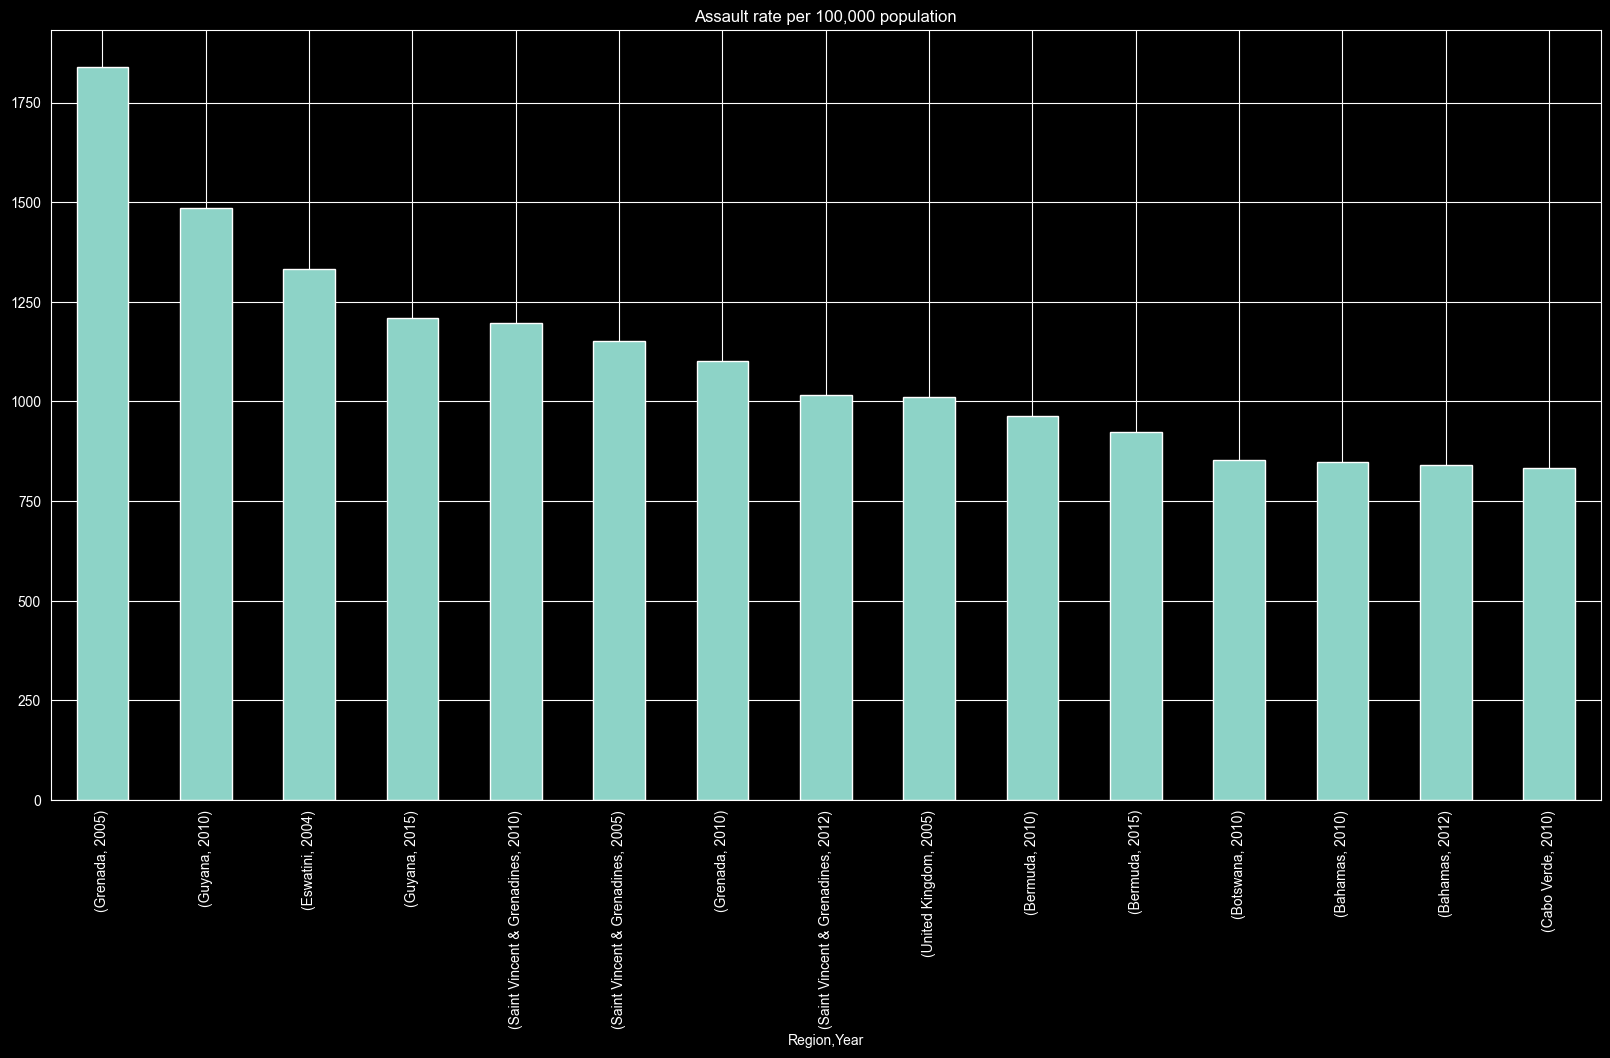

In [92]:
pivoted_max3=pivoted_max.sort_values(by="Assault rate per 100,000 population",ascending=False)
fig, ax = plt.subplots(figsize=(20, 10))
pivoted_max3["Assault rate per 100,000 population"].head(15).plot(kind='bar', rot=90,  title='Assault rate per 100,000 population')

In [93]:
del pivoted_max3,pivoted_max,df,pivoted_max2,pivoted


gc.collect()

3206

Some interesting plots (albeit not complete data! only introductory!) but it seems that there is a suprising prevelance of assault rate in unexpected places(as already stated in the beginning). Sweden, Belgium, Germany certainly do not classify as dangerous places to live. Assumption is that these countries have better/more effective police force that is able to cover and handle these types of crimes more effectively hence there are more assaults. If we were to compare that with worse crimes like murder, than the police can not look the other way and it is well documented that usuall countries will the top of the list.

# Nationmaster

Starting of with finding the crime data for the whole world, for a big number of years:

In [94]:
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20


In [95]:
nm = pd.read_csv('/Users/margarita/Downloads/Nationmaster.csv', encoding='latin1')
nm.rename(columns={'Unnamed: 0': "Country"}, inplace=1)
nm.shape


(234, 80)

In [96]:
#dropping data that is irrelevant and 
nm.drop(columns=[
	"Age of criminal responsibility %28notes%29", "Background",
	"Illicit drugs",
	"Minimum to serve before eligibility for requesting parole",
	"Prosecution rate",
	"Prosecution rate per million",
	"%25 sales"
], inplace=True)

print("deleting average countries: \n", nm[nm["Country"].str.match(".*average")]["Country"])
nm.drop(nm[nm["Country"].str.match(".*average")].index, inplace=True)


deleting average countries: 
 45                      Eastern Europe average
52             Former Soviet republics average
97                      NATO countries average
98                      European Union average
122          Group of 7 countries (G7) average
141                           Eurozone average
144                   Emerging markets average
172         High income OECD countries average
173            Non-religious countries average
180                             Europe average
207         Heavily indebted countries average
208            Former British colonies average
209                     OPEC countries average
210            Former Spanish colonies average
211    Middle Eastern and North Africa average
212                   Muslim countries average
213        Latin America and Caribbean average
214             Former French colonies average
231                         South Asia average
232             South and Central Asia average
Name: Country, dtype: object


In [97]:
#dropping countries we do not have data about
limit = 20  # drop all countries with data in less than x columns
bad_countries = (~nm.isna()).sum(axis=1)
print("deleting ", (bad_countries < 20).sum())
nm.drop(nm[bad_countries < 20].index, inplace=True)
nm.shape


deleting  107


(107, 73)

In [98]:
import plotly.offline as py

import plotly.graph_objs as go

py.init_notebook_mode(connected=True)

In [99]:
countriesraw = pd.read_csv('/Users/margarita/Downloads/2014_world_gdp_with_codes.csv')
countries=countriesraw.copy()

countries["Country"]=countries["COUNTRY"]
countries=countries.drop(columns=["COUNTRY"])

nm.reset_index(inplace=True)

nm=nm.merge(countries,how="outer")

nm.sort_index(inplace=True)
nm.set_index("Country",inplace=True)
nm.columns

Index(['index',
       '%25 of managers surveyed ranking this as a major business constraint',
       'Acquitted', 'Acquitted per 1000', 'Adults prosecuted',
       'Adults prosecuted per 1000', 'Age of criminal responsibility',
       'Assault rate', 'Assault victims', 'Assaults', 'Auto theft',
       'Believe in police efficiency',
       'Believes crime increasing in the past 3 years', 'Bribery victims',
       'Burglaries', 'Car thefts', 'Car thefts per 1000', 'Convictions',
       'Convictions per 1000', 'Counterfeiting', 'Counterfeiting per million',
       'Crime levels', 'Drug offences', 'Drug related crime',
       'Drug trafficking', 'Embezzlements', 'Embezzlements per million',
       'Executions', 'Executions per million', 'Females prosecuted',
       'Females prosecuted per 1000', 'Frauds', 'Frauds per 1000', '2007',
       'Term End', 'Jails', 'Jails per million', 'Judges',
       'Judges and Magistrates', 'Judges and Magistrates per million',
       'Kidnappings', 'Mansl

In [100]:
column_name='Total crimes per 1000'
data = [ dict(
        type = 'choropleth',
        locations = nm['CODE'],
        z = nm[column_name].fillna(0),
        text = nm.index,
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            title = column_name),
      ) ]

layout = dict(
    title = 'world plot of '+column_name,
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )

nm[[column_name]].sort_values(by=column_name,ascending=0)


,Total crimes per 1000
Country,
Iceland,209.520630
Sweden,138.351800
United Kingdom,109.964046
New Zealand,108.200582
Finland,100.025805
...,...
Uzbekistan,NaN
Vanuatu,NaN
Vietnam,NaN


WHAT? It does not make any sence. Sweden? It is because people have more trust, less corruption, better reporting system punishments etc... IN ORDER To mitigate this effect and get the TRUE levels we ought to normalise these values with all of the values/data that I just named, and even more since these are (probably) correct assumptions of why the results are odd. 

# Importing UNO DC Crime data

In [122]:
unodc=None
fields=["Assault","Kidnapping","Theft","Robbery","Burglary","Domestic_Burglary","Theft_of_Private_Cars","Motor_Vehicle_Theft",
        "Total_Sexual_Violence","Rape","Sexual_Offences_ag_Children"]
string="abcdefghijk"

for i in range(len(string)):
    l=string[i]
    names=["%s_Rel_20%02d"%(fields[i],j) for j in range(3,15)]
    
    tmp= pd.read_csv('/Users/margarita/Downloads/Publication Reports_1%s.csv'%l,sep=";",index_col=[2],header=None,skipinitialspace=True,skiprows=10, encoding='latin1',
                 names=[
        "Region","Sub-Region","Country",
        *["%s_Abs_20%02d"%(fields[i],j) for j in range(3,15)],
                     "nothing",
        *["%s_Rel_20%02d"%(fields[i],j) for j in range(3,15)]  
        ],
        
    )
    tmp.reset_index(inplace=True)
    tmp["Country"]=tmp["Country"].str.replace("*","").str.replace(" of America","").str.replace(" (England and Wales)","",regex=False).str.replace("Russian Federation","Russia").str.replace("Republic of ","").str.replace(" (Plurinational State of)","",regex=False).str.replace("Korea","Korea, South",regex=False)
    tmp.set_index("Country",inplace=True)
    tmp.drop(columns=["Region","Sub-Region","nothing"],inplace=True)
    for n in names:
        # Replace periods and commas, while handling possible non-numeric values
        tmp[n] = tmp[n].str.replace(".", "", regex=True)
        tmp[n] = tmp[n].str.replace(",([0-9])$", lambda m: "." + m[1], regex=True)

        # Convert to float, while replacing empty strings or invalid entries with NaN
        tmp[n] = pd.to_numeric(tmp[n], errors='coerce')

    tmp=tmp.loc[tmp.index.dropna()]
    
    unodc=tmp  if unodc is None else unodc.merge(tmp,how="outer",on="Country")
unodc.drop("Country/territory",inplace=True)
#unodc.rename(columns={'Country/territory':'Subcontinent'},inplace=True)

In [124]:
countries=pd.read_csv('/Users/margarita/Downloads/2014_world_gdp_with_codes.csv')
countries["Country"]=countries["COUNTRY"]
countries=countries.drop(columns=["COUNTRY","GDP (BILLIONS)"])


#unodc["CC"]=countries.loc[unodc["Country"].str.replace("*","")].reset_index()["CODE"]
unodc=unodc.reset_index().merge(countries,how="outer")

unodc.sort_index(inplace=True)
unodc.set_index("Country",inplace=True)

In [125]:
unodc_avg_year=pd.DataFrame()
unodc_avg=pd.DataFrame()
unodc_max_cat=pd.DataFrame()
for f in fields: # trying to use only these to not let rare crimes play big role, but no difference:
                #["Robbery","Assault","Kidnapping","Burglary","Theft_of_Private_Cars"]:
    names=["%s_Rel_20%02d"%(f,j) for j in range(3,15)]
    unodc_avg_year[f]=unodc[names].mean(axis=1)
un_fields=['Assault rate Rel',
       'Intentional homicide rates Rel',
       'Kidnapping at the national level, rate Rel',
       'Percentage of male and female intentional homicide victims, Female',
       'Percentage of male and female intentional homicide victims, Male',
       'Robbery at the national level, rate Rel',
       'Theft at the national level, rate Rel',
       'Total Sexual Violence at the national level, rate Rel']
for f in un_fields:
    print(f)
    names=["%s_Rel_20%02d"%(f,j) for j in range(3,15)]
    unodc_avg_year[f]=unodc_un[f].unstack(level=1).astype(float).mean(axis=1)
    
unodc_avg_year-=unodc_avg_year.mean()
unodc_avg_year/=unodc_avg_year.std()
unodc_avg["crime_score"]=unodc_avg_year.mean(axis=1)
unodc_avg["crime_score"]-=unodc_avg["crime_score"].min()
unodc_avg["crime_score"].fillna(0,inplace=True)
unodc_avg["CODE"]=unodc["CODE"]
unodc_avg_year.loc[["United States","Sweden","Austria","Mexico","Morocco","Serbia"]]

Assault rate Rel
Intentional homicide rates Rel
Kidnapping at the national level, rate Rel
Percentage of male and female intentional homicide victims, Female
Percentage of male and female intentional homicide victims, Male
Robbery at the national level, rate Rel
Theft at the national level, rate Rel
Total Sexual Violence at the national level, rate Rel


,Assault,Kidnapping,Theft,Robbery,Burglary,Domestic_Burglary,Theft_of_Private_Cars,Motor_Vehicle_Theft,Total_Sexual_Violence,Rape,Sexual_Offences_ag_Children,Assault rate Rel,Intentional homicide rates Rel,"Kidnapping at the national level, rate Rel","Percentage of male and female intentional homicide victims, Female","Percentage of male and female intentional homicide victims, Male","Robbery at the national level, rate Rel","Theft at the national level, rate Rel","Total Sexual Violence at the national level, rate Rel"
Country,,,,,,,,,,,,,,,,,,,
United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.371585,-0.209416,NaN,-0.044640,-0.198675,0.131707,1.455763,NaN
Sweden,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.550426,-0.610148,NaN,-0.724834,-0.534884,-0.013229,3.949298,3.031447
Austria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.524954,-0.645412,-0.625025,-0.753779,-0.571500,-0.290774,1.293801,0.033346
Mexico,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.084982,0.819663,-0.400903,0.490833,0.813282,1.841115,-0.722692,-0.072365
Morocco,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.139978,-0.575525,-0.123419,-0.811668,-0.498267,-0.238486,-0.544628,-0.608914
Serbia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.636730,-0.571677,-0.571663,-0.623529,-0.506589,-0.375470,-0.605218,-0.709295


In [145]:
unodc_avg

,crime_score,CODE
Country,,
Burundi,0.262898,BDI
Kenya,0.286815,KEN
Mauritius,0.552207,MUS
Mozambique,0.166626,MOZ
Rwanda,0.224954,RWA
...,...,...
Venezuela,0.000000,VEN
Vietnam,0.000000,VNM
Virgin Islands,0.000000,VGB


In [126]:
column_name="crime_score"
data = [ dict(
        type = 'choropleth',
        locations = unodc_avg['CODE'],
        z = unodc_avg['crime_score'],
        text = unodc.index,
        colorscale =[[0.0, 'rgb(255,255,255)'],[1e-6, 'rgb(237,235,242)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']],
        autocolorscale = False,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            #autotick = False,
            title = column_name.replace("_"," ")),
      ) ]

layout = dict(
    title = 'world plot of '+column_name.replace("_"," "),
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )
#import plotly.io as pio
#pio.write_image(fig, 'world_avg_cr.pdf')
unodc_avg[["crime_score"]].sort_values(by="crime_score",ascending=False)[:10]

,crime_score
Country,
South Africa,3.268815
El Salvador,3.010446
Honduras,2.192652
Jamaica,2.124834
Bahamas,2.063483
Lesotho,2.054194
Grenada,1.974978
Saint Kitts and Nevis,1.927792
Saint Lucia,1.919666


In [127]:
corruption=pd.read_csv("/Users/margarita/Downloads/theglobaleconomy_corruption.csv", sep=", ")
corruption["Rule of law"]=corruption["Rule of law"].astype(float)

corruption["Corruption perceptions - Transparency International"]=corruption["Corruption perceptions - Transparency International"].str.replace(",","").fillna(-1).astype(int).replace(-1, np.nan)
corruption.set_index(["Country","Code","Year"],inplace=True)
corruption_avg=pd.DataFrame()
corruption
corruption_avg["Rule of law"]=2.5-corruption["Rule of law"].unstack(level=2).mean(axis=1)
corruption_avg["Corruption Perception"]=100-corruption["Corruption perceptions - Transparency International"].unstack(level=2).mean(axis=1)
corruption_avg[["Rule of law","Corruption Perception"]]-=corruption_avg[["Rule of law","Corruption Perception"]].mean(axis=0)
corruption_avg[["Rule of law","Corruption Perception"]]/=corruption_avg[["Rule of law","Corruption Perception"]].std(axis=0)
corruption_avg["corruption_score"]=corruption_avg.mean(axis=1)
corruption_avg.reset_index(inplace=True)
corruption_avg.set_index(["Country"],inplace=True)
corruption_avg[:10]

,Code,Rule of law,Corruption Perception,corruption_score
Country,,,,
Afghanistan,AFG,1.692312,1.563656,1.627984
Albania,ALB,0.516100,0.554086,0.535093
Algeria,DZA,0.711616,0.516025,0.613820
Andorra,AND,-1.318323,NaN,-1.318323
Angola,AGO,1.283364,1.064104,1.173734
Antigua and Barbuda,ATG,-0.861860,NaN,-0.861860
Argentina,ARG,0.648521,0.569310,0.608916
Armenia,ARM,0.382900,0.527443,0.455171
Aruba,ABW,-1.172465,NaN,-1.172465


In [128]:
column_name="corruption"
data = [ dict(
        type = 'choropleth',
        locations = corruption_avg['Code'],
        z = corruption_avg['corruption_score'],
        text = corruption_avg.index,
        colorscale =[[0.0, 'rgb(255,255,255)'],[1e-6, 'rgb(237,235,242)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']],
        autocolorscale = False,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            #autotick = False,
            title = column_name.replace("_"," ")),
      ) ]

layout = dict(
    title = 'world plot of '+column_name.replace("_"," "),
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )
#import plotly.io as pio
#pio.write_image(fig, 'world_avg_cr.pdf')
corruption_avg[["corruption_score"]].sort_values(by="corruption_score",ascending=False)[:10]

,corruption_score
Country,
Somalia,1.923965
Afghanistan,1.627984
North Korea,1.488615
Iraq,1.384190
Burma (Myanmar),1.336567
Zimbabwe,1.317133
Turkmenistan,1.308093
Venezuela,1.308023
Democratic Republic of the Congo,1.289816


In [129]:
unodc_w=unodc_avg.reset_index().merge(corruption_avg,left_on="CODE",right_on="Code").set_index("Country")
unodc_w["crime_score_w"]=unodc_w["crime_score"]+(unodc_w["corruption_score"]/3)
unodc_w.sort_values(by="crime_score_w",ascending=False)[:10]

,crime_score,CODE,Code,Rule of law,Corruption Perception,corruption_score,crime_score_w
Country,,,,,,,
South Africa,3.268815,ZAF,ZAF,-0.174048,-0.205233,-0.189640,3.205601
El Salvador,3.010446,SLV,SLV,0.574521,0.150638,0.362580,3.131306
Honduras,2.192652,HND,HND,0.905574,0.763422,0.834498,2.470818
Jamaica,2.124834,JAM,JAM,0.336163,0.299077,0.317620,2.230708
Lesotho,2.054194,LSO,LSO,0.149215,0.152368,0.150792,2.104458
Guinea-Bissau,1.704830,GNB,GNB,1.299722,1.056492,1.178107,2.097532
Guyana,1.825976,GUY,GUY,0.517658,0.723630,0.620644,2.032857
Grenada,1.974978,GRD,GRD,-0.203648,0.363780,0.080066,2.001666
Belize,1.668654,BLZ,BLZ,0.287089,0.281315,0.284202,1.763388


In [130]:
column_name="crime_score_including_corruption"
data = [ dict(
        type = 'choropleth',
        locations = unodc_w['CODE'],
        z = unodc_w['crime_score_w'],
        text = unodc_w.index,
        colorscale =[[0.0, 'rgb(255,255,255)'],[1e-6, 'rgb(237,235,242)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']],
        autocolorscale = False,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            #autotick = False,
            title = column_name.replace("_"," ")),
      ) ]

layout = dict(
    title = 'world plot of '+column_name.replace("_"," "),
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )
#import plotly.io as pio
#pio.write_image(fig, 'world_avg_cr.pdf')

# ECONOMIC FACTORS


In this section we are going to load and preprocess data concerning economic factors such as: Inflation rate, Unemployment rate and GDP per capita. We have chosen this three factors because we think they are the most important and a lot of other factors are highly correlated to this three. With this and social factors data sets we are trying to answer the question: "Are there typical characteristics of countries with high/low crime rates?".

In [131]:
df_gdp = pd.read_excel("/Users/margarita/Downloads/gdp_world.xlsx")
df_inf = pd.read_excel("/Users/margarita/Downloads/inf_world.xlsx")
df_unemp = pd.read_excel("/Users/margarita/Downloads/unemp_world.xlsx")
print(type(df_gdp),type(df_inf),type(df_unemp))
df_gdp.rename(columns={"Real GDP growth (Annual percent change)": "Country"}, inplace=True)
columns_to_convert = df_gdp.columns.difference(['Country'])  # Select all columns except 'Country'
df_gdp[columns_to_convert] = df_gdp[columns_to_convert].apply(pd.to_numeric, errors='coerce')  # Convert to numeric
#df_gdp_sum = df_gdp.drop(columns=['Country']).sum(axis=1)  # Drop 'Country' and sum

df_inf.rename(columns={"Inflation rate, average consumer prices (Annual percent change)": "Country"}, inplace=True)
columns_to_convert = df_inf.columns.difference(['Country'])  # Select all columns except 'Country'
df_inf[columns_to_convert] = df_inf[columns_to_convert].apply(pd.to_numeric, errors='coerce')  # Convert to numeric
#df_inf_sum = df_inf.drop(columns=['Country']).sum(axis=1)  # Drop 'Country' and sum

df_unemp.rename(columns={"Unemployment rate (Percent)": "Country"}, inplace=True)
columns_to_convert = df_unemp.columns.difference(['Country'])  # Select all columns except 'Country'
df_unemp[columns_to_convert] = df_unemp[columns_to_convert].apply(pd.to_numeric, errors='coerce')  # Convert to numeric
#df_unemp_sum = df_unemp.drop(columns=['Country']).sum(axis=1)  # Drop 'Country' and sum
df_gdp

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.4,-14.5,-6.2,2.7,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,2.7,5.7,2.9,1.1,2.0,-1.5,5.6,-0.8,-1.4,...,-3.3,8.9,4.9,3.5,3.3,3.4,3.5,3.5,3.5,3.5
3,Algeria,-5.4,3.0,6.4,5.4,5.6,5.6,-0.2,-0.7,-1.9,...,-5.0,3.8,3.6,4.1,3.8,3.0,2.5,2.1,2.1,2.1
4,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-11.2,8.3,9.6,1.4,1.4,1.6,1.5,1.5,1.5,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,Other advanced economies,3.6,4.2,2.2,4.0,6.5,4.4,5.5,6.5,5.5,...,-1.6,5.9,2.7,1.8,2.1,2.2,2.3,2.2,2.2,2.1
227,Sub-Saharan Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.6,4.8,4.1,3.6,3.6,4.2,4.4,4.3,4.4,4.4
228,World,2.2,2.0,0.7,2.7,4.6,3.7,3.4,3.9,4.5,...,-2.7,6.6,3.6,3.3,3.2,3.2,3.3,3.2,3.1,3.1
229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
df_gdp_sum = df_gdp[['Country']].join(df_gdp.drop(columns=['Country']).sum(axis=1).rename("GDP_Sum"), how='left')

df_inf_sum = df_inf[['Country']].join(df_inf.drop(columns=['Country']).sum(axis=1).rename("Inflation_Sum"), how='left')
print(df_inf_sum)
df_unemp_sum = df_unemp[['Country']].join(df_unemp.drop(columns=['Country']).sum(axis=1).rename("Unemployment_Sum"), how='left')

df8 = df_gdp_sum.merge(df_inf_sum, on="Country", how="inner").merge(df_unemp_sum, on="Country", how="inner")

# Drop rows with any missing values
df8 = df8.dropna()

# Save to CSV
df8.to_csv("Total_econom.csv", index=False)


                      Country  Inflation_Sum
0                         NaN            0.0
1                 Afghanistan          163.3
2                     Albania          523.1
3                     Algeria          404.1
4                     Andorra           57.7
..                        ...            ...
225  Other advanced economies          225.8
226        Sub-Saharan Africa          397.1
227                     World          475.6
228                       NaN            0.0
229                ©IMF, 2024            0.0

[230 rows x 2 columns]


As we can see this data set goes from 2000 to 2015 and there are still some non-existent values that we need to fill with right sources or best techiniques possible. First we are going to change names of some columns and drop one column and then fill the data set.

In [113]:
df8

,Country,GDP_Sum,Inflation_Sum,Unemployment_Sum
8,Albania,148.2,523.1,609.9
9,Algeria,126.0,404.1,717.7
10,Andorra,48.4,57.7,57.2
11,Argentina,93.8,897.4,479.9
12,Armenia,199.3,9332.0,581.7
...,...,...,...,...
122,Advanced economies,114.3,159.0,318.5
123,Euro area,55.4,85.3,347.5
124,Major advanced economies (G7),104.7,145.0,302.3
125,Other advanced economies,178.0,225.8,224.6


## FILLING THE DATA SET

Preparing data set on economic factors for merging

In [133]:
#setting all values as floats
df8.loc[:,'Inflation rate(%)'] = df8.loc[:,'Inflation_Sum'].astype('float')/100
#we want to have unemployment per capita for our last model so I am dividing whole column with 100
df8.loc[:,'Unemployment rate(%)'] = df8.loc[:,'Unemployment_Sum'].astype('float')/100
df8.loc[:,'GDP per capita'] = df8.loc[:,'GDP_Sum'].astype('float') 

cols3 = list(df8.columns)
df8.columns = cols3
#pd.set_option('display.max_rows',3000)
df_econ_max=df8
df8.head()

,Country,GDP_Sum,Inflation_Sum,Unemployment_Sum,Inflation rate(%),Unemployment rate(%),GDP per capita
8,Albania,148.2,523.1,609.9,5.231,6.099,148.2
9,Algeria,126.0,404.1,717.7,4.041,7.177,126.0
10,Andorra,48.4,57.7,57.2,0.577,0.572,48.4
11,Argentina,93.8,897.4,479.9,8.974,4.799,93.8
12,Armenia,199.3,9332.0,581.7,93.320,5.817,199.3


## PLOTTING

### GDP PER CAPITA PLOT

In [134]:
df8_plot=df8.reset_index()

column_name='GDP per capita'
data = [ dict(
        type = 'choropleth',
        locations = df8_plot['Country'].astype(str),
        locationmode = 'country names',
        z = df8_plot[column_name].astype(float),
        #text = df8['Code'].astype(str),
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            title = column_name),
      ) ]

layout = dict(
    title = 'world plot of GDP per capita (2000)',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d8-world-map' )


### INFLATION RATE PLOT

In [117]:
column_name='Inflation rate(%)'
data = [ dict(
        type = 'choropleth',
        locations = df8_plot['Country'].astype(str),
        locationmode = 'country names',
        z = df8_plot[column_name].astype(float),
        #text = df8['Code'].astype(str),
        colorscale = [[0,"rgb(172, 10, 5)"],[0.35,"rgb(190, 60, 40)"],[0.5,"rgb(245, 100, 70)"],\
            [0.6,"rgb(245, 120, 90)"],[0.7,"rgb(247, 137, 106)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            title = column_name),
      ) ]

layout = dict(
    title = 'world plot of Inflation rate (2000)',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d8-world-map' )

### UNEMPLOYMENT RATE PER CAPITA PLOT

In [118]:
column_name='Unemployment rate(%)'
data = [ dict(
        type = 'choropleth',
        locations = df8_plot['Country'].astype(str),
        locationmode = 'country names',
        z = df8_plot[column_name].astype(float),
        #text = df8['Code'].astype(str),
        colorscale = [[0,"rgb(5, 172, 10)"],[0.35,"rgb(40, 190, 60)"],[0.5,"rgb(70, 245, 100)"],\
            [0.6,"rgb(90, 245, 120)"],[0.7,"rgb(106, 247, 137)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            title = column_name),
      ) ]

layout = dict(
    title = 'world plot of Unemployment rate per capita (2000)',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d8-world-map' )


WE have seen how crime indicators moves with other socio-economiv indicators. Let us quantify it in a corr plot.

To create a target variable we will use the normalised aggregated crime rates from before:

In [135]:
crime_normalised=unodc_avg["crime_score"].reset_index()

In [159]:
df_all = pd.DataFrame()
#df_all["total_crime"]=crime_normalised["crime_score"]
df_all = unodc_avg.merge(df8, on="Country", how="inner")
df_all.drop(columns = ['GDP_Sum', 'Inflation_Sum', 'Unemployment_Sum'], inplace=True)
df_all

,Country,crime_score,CODE,Inflation rate(%),Unemployment rate(%),GDP per capita
0,Mauritius,0.552207,MUS,3.316,3.699,208.4
1,Algeria,0.206323,DZA,4.041,7.177,126.0
2,Egypt,0.071329,EGY,6.172,3.773,228.5
3,Morocco,0.273290,MAR,1.757,4.001,180.2
4,Cabo Verde,1.653141,CPV,2.470,8.777,250.3
...,...,...,...,...,...,...
97,Syria,0.000000,SYR,3.647,1.515,131.6
98,Tunisia,0.263342,TUN,2.914,5.206,157.8
99,Uzbekistan,0.302850,UZB,36.030,1.627,182.5
100,Venezuela,0.000000,VEN,917.866,2.741,-30.9


In [160]:
df_all.interpolate(method='linear',inplace=True)
df_all

,Country,crime_score,CODE,Inflation rate(%),Unemployment rate(%),GDP per capita
0,Mauritius,0.552207,MUS,3.316,3.699,208.4
1,Algeria,0.206323,DZA,4.041,7.177,126.0
2,Egypt,0.071329,EGY,6.172,3.773,228.5
3,Morocco,0.273290,MAR,1.757,4.001,180.2
4,Cabo Verde,1.653141,CPV,2.470,8.777,250.3
...,...,...,...,...,...,...
97,Syria,0.000000,SYR,3.647,1.515,131.6
98,Tunisia,0.263342,TUN,2.914,5.206,157.8
99,Uzbekistan,0.302850,UZB,36.030,1.627,182.5
100,Venezuela,0.000000,VEN,917.866,2.741,-30.9


In [161]:
df_all.fillna(method="bfill",inplace=True)
df_all.fillna(method="ffill",inplace=True)
df_all.head()

crime_score             float64
CODE                     object
Inflation rate(%)       float64
Unemployment rate(%)    float64
GDP per capita          float64
dtype: object


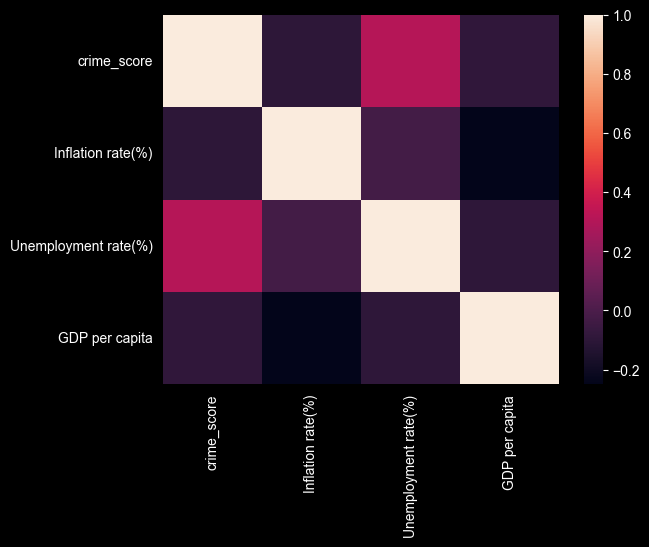

In [167]:
#df_all.drop(['Country'],axis=1,inplace=True)
print(df_all.dtypes)
# calculate the correlation matrix
corr = df_all.drop(columns=["CODE"]).corr()

# plot the heatmap
sns_plot2=sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)


(interesting and some) Conclusions from the correlation matrix: 

*  WE can see some correlation between crimes and inflation rate & GDP rate


To answer the last question we are going to build a model and try to predict all of the crimes combined using other factors

In [169]:
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
import statsmodels.api as sm


In [170]:
X = df_all[['GDP per capita', 'Inflation rate(%)', 'Unemployment rate(%)']]  # Independent variables
y = df_all['crime_score']  # Dependent variable

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the OLS regression
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            crime_score   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     4.189
Date:                Sun, 29 Dec 2024   Prob (F-statistic):            0.00779
Time:                        04:40:55   Log-Likelihood:                -90.289
No. Observations:                 102   AIC:                             188.6
Df Residuals:                      98   BIC:                             199.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.4926 

In [171]:
import statsmodels.stats.diagnostic as sms

def breusch_pagan_test(model):
    # Perform the Breusch-Pagan test
    test_results = sms.het_breuschpagan(model.resid, model.model.exog)
    
    # Unpack test results
    lm_statistic, lm_p_value, f_statistic, f_p_value = test_results
    
    # Print results
    print(f"Breusch-Pagan F-statistic: {f_statistic}")
    print(f"Breusch-Pagan F P-value: {f_p_value}")
    
    # Interpretation of the test
    alpha = 0.05
    if lm_p_value < alpha:
        print("Reject the null hypothesis: Evidence of heteroscedasticity.")
    else:
        print("Fail to reject the null hypothesis: No evidence of heteroscedasticity.")


In [176]:
breusch_pagan_test(model)

Breusch-Pagan LM Statistic: 11.902430831152133
Breusch-Pagan LM P-value: 0.007724975265308009
Breusch-Pagan F-statistic: 4.315463159229592
Breusch-Pagan F P-value: 0.006663393531753276
Reject the null hypothesis: Evidence of heteroscedasticity.


In [177]:
def white_test(model):
    # Perform the White test for heteroscedasticity
    test_results = sms.het_white(model.resid, model.model.exog)
    
    # Unpack test results
    white_statistic, white_p_value, _, _ = test_results
    
    # Print results
    print(f"White Test Statistic: {white_statistic}")
    print(f"White Test P-value: {white_p_value}")
    
    # Interpretation of the test
    alpha = 0.05
    if white_p_value < alpha:
        print("Reject the null hypothesis: Evidence of heteroscedasticity.")
    else:
        print("Fail to reject the null hypothesis: No evidence of heteroscedasticity.")


In [178]:
white_test(model)

White Test Statistic: 15.985563807244388
White Test P-value: 0.0671836658953543
Fail to reject the null hypothesis: No evidence of heteroscedasticity.


In [173]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# Calculate VIF for each feature in the model
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the results
print(vif_data)


                feature       VIF
0                 const  9.890084
1        GDP per capita  1.078705
2     Inflation rate(%)  1.069691
3  Unemployment rate(%)  1.012064


In [174]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = model.predict(X_test)

# Bias calculation
bias = np.mean(y_pred) - np.mean(y_test)
print("Bias:", bias)

# MSE Calculation
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

# RMSE Calculation (square root of MSE)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

# Standard Error Calculation for residuals
residuals = y_test - y_pred
se = np.std(residuals, ddof=1)  # ddof=1 for sample standard deviation
print("Standard Error:", se)


Bias: -0.08415606343270587
MSE: 0.5446859175245785
RMSE: 0.73802839886049
Standard Error: 0.7513214080789214


In [175]:
def plot_resid(model):
    # Get residuals from the model
    residuals = model.resid
    
    # Create a figure and axis for the plot
    plt.figure(figsize=(10, 6))
    
    # Plot the residuals vs the fitted values (predictions)
    plt.subplot(1, 2, 1)
    sns.residplot(x=model.fittedvalues, y=residuals, lowess=True, line_kws={'color': 'red'})
    plt.title('Residuals vs Fitted Values')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    
    # Plot the histogram of the residuals to check for normality
    plt.subplot(1, 2, 2)
    sns.histplot(residuals, kde=True, color='blue', bins=20)
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    
    # Show the plots
    plt.tight_layout()
    plt.show()
    

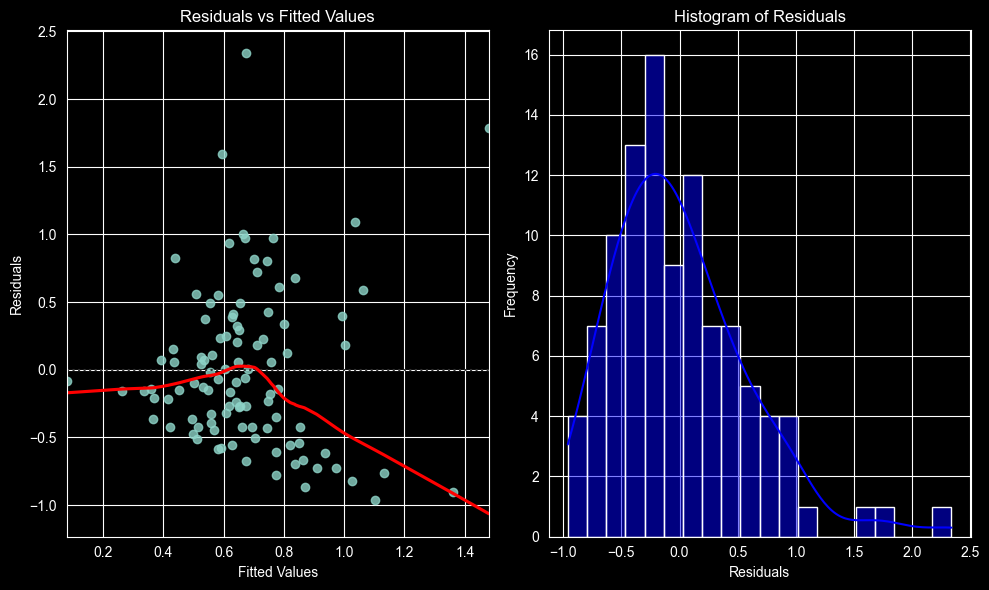

In [179]:
plot_resid(model)